In [18]:
##Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, classification_report, f1_score
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler

def balance(data): #sample it down to 1200 to balance out
    zero = data[data['Potability']==0] #has 1200
    one = data[data['Potability']==1] #has 811
    resampledData = resample(one, n_samples=1998)
    updatedData = shuffle(pd.concat([zero, resampledData]))
    return updatedData

def variableClean(data):
    indepVariable = data.drop('Potability', axis=1).copy()
    depVariable = data['Potability'].copy()
    scal = StandardScaler()
    features = indepVariable.columns
    indepVariable[features] = scal.fit_transform(indepVariable[features])
    return indepVariable, depVariable

def getMax(arr):
    maxVal = -1
    index = -1
    for i in range(len(arr)):
        if(maxVal < arr[i]):
            maxVal = arr[i]
            index = i
    return {'index': index,
           'maximum_value': maxVal}

def getScore(trainSize, testMean):
    max_test = getMax(testMean)
    index = max_test['index']
    maxValue = max_test['maximum_value']
    optimalTrainSize = trainSize[index]
    conclusion = f'With the train size of {optimalTrainSize} yields the score of {maxValue}.'
    return conclusion

def prediction(df, xTrain, yTrain, xTest, yTest):
    output = {}
    start = time.time()
    df.fit(xTrain, yTrain)
    test_pred = df.predict(xTest)
    cRep = classification_report(yTest, test_pred, digits=4)
    f1Score = f1_score(yTest, test_pred)
    end = time.time()
    wallClockPred = end - start
    outputUpdate = (('classification_report', cRep), ('f1_score', f1Score), ('wall_clock', wallClockPred))
    output.update(outputUpdate)
    return output

def printPredictions(pred):
    print('Time spent for prediction: ', pred['wall_clock'])
    print(pred['classification_report'])
    print('f1-Score: ', pred['f1_score'])


In [19]:
##Data source: https://www.kaggle.com/adityakadiwal/water-potability
original_data = pd.read_csv('/Users/jacobseo/cs7641/assignment1/data/water_potability.csv')
df = original_data.copy()

df['ph'].fillna(value=df['ph'].median(),inplace=True)
df['Sulfate'].fillna(value=df['Sulfate'].median(),inplace=True)
df['Trihalomethanes'].fillna(value=df['Trihalomethanes'].median(),inplace=True)

df.isnull().sum()

df = balance(df)
df.Potability.value_counts()

#X, y = variableClean(df)

0    1998
1    1998
Name: Potability, dtype: int64

[learning_curve] Training set sizes: [  29   58   88  117  147  176  206  235  265  294  324  353  383  412
  442  471  501  530  560  589  619  648  678  707  737  766  795  825
  854  884  913  943  972 1002 1031 1061 1090 1120 1149 1179 1208 1238
 1267 1297 1326 1356 1385 1415 1444 1474 1503 1532 1562 1591 1621 1650
 1680 1709 1739 1768 1798 1827 1857 1886 1916 1945 1975 2004 2034 2063
 2093 2122 2152 2181 2211 2240 2269 2299 2328 2358 2387 2417 2446 2476
 2505 2535 2564 2594 2623 2653 2682 2712 2741 2771 2800 2830 2859 2889
 2918 2948]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 out of 1000 | elapsed:    2.5s remaining:   24.9s
[Parallel(n_jobs=-1)]: Done 193 out of 1000 | elapsed:    4.8s remaining:   20.2s
[Parallel(n_jobs=-1)]: Done 294 out of 1000 | elapsed:    7.2s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done 395 out of 1000 | elapsed:    9.4s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done 496 out of 1000 | elapsed:   11.6s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done 597 out of 1000 | elapsed:   13.8s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done 698 out of 1000 | elapsed:   16.0s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done 799 out of 1000 | elapsed:   18.2s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done 900 out of 1000 | elapsed:   20.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   22.6s finished


'With the train size of 88 yields the score of 0.6184269411501455.'

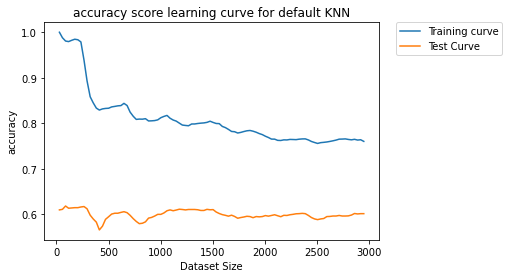

In [20]:
##Default learning Curve
train_sizes, train_scores, test_scores = learning_curve(KNeighborsClassifier(), X, y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01,1.0,100), verbose=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training curve')
plt.plot(train_sizes, test_mean, label='Test Curve')
plt.xlabel("Dataset Size")
plt.ylabel("accuracy")
plt.title("accuracy score learning curve for default KNN")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

getScore(train_sizes, test_mean)

In [21]:
##Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

##GridSearch
params = {
    'n_neighbors': [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144],
    'weights': ['distance', 'uniform']
}

gs = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=10, n_jobs=-1, verbose=10, return_train_score=True, scoring='accuracy')
gs.fit(X_train, y_train)

##Best Results
best_parameter = gs.best_params_
best_score = gs.best_score_

print("best parameter: ", best_parameter)
print("best score: ", best_score)

Fitting 10 folds for each of 22 candidates, totalling 220 fits
best parameter:  {'n_neighbors': 34, 'weights': 'distance'}
best score:  0.6553626196241208


In [22]:
results_data = pd.DataFrame(gs.cv_results_)
param_keys = list(params.keys())
optimal_results_data = results_data.loc[(results_data['param_'+param_keys[1]]==best_parameter[param_keys[1]])]
optimal_results_data

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.005816,0.000956,0.015705,0.001387,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.633898,0.569492,0.610169,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.005643,0.000792,0.019096,0.001364,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.633898,0.569492,0.610169,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.005807,0.000694,0.023774,0.004566,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.630508,0.633898,0.616949,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,0.007471,0.001873,0.026426,0.003418,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.610169,0.640678,0.674576,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
8,0.007733,0.001401,0.031650,0.004721,8,distance,"{'n_neighbors': 8, 'weights': 'distance'}",0.647458,0.627119,0.674576,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
10,0.007157,0.002326,0.027517,0.003262,13,distance,"{'n_neighbors': 13, 'weights': 'distance'}",0.627119,0.667797,0.674576,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
12,0.005845,0.000649,0.030997,0.003927,21,distance,"{'n_neighbors': 21, 'weights': 'distance'}",0.633898,0.661017,0.654237,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
14,0.005541,0.000603,0.031480,0.003313,34,distance,"{'n_neighbors': 34, 'weights': 'distance'}",0.637288,0.644068,0.681356,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
16,0.005577,0.000592,0.037002,0.004918,55,distance,"{'n_neighbors': 55, 'weights': 'distance'}",0.630508,0.644068,0.654237,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
18,0.005515,0.000315,0.039117,0.002703,89,distance,"{'n_neighbors': 89, 'weights': 'distance'}",0.630508,0.647458,0.644068,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


Text(0.5, 1.0, 'Validation for the KNN')

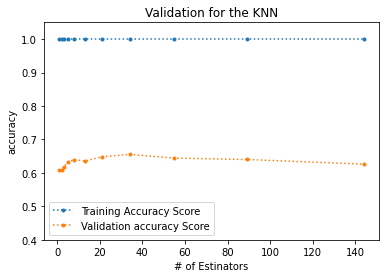

In [23]:
##GridSearch Plotting
fig, ax = plt.subplots()
optimal_results_data.plot(x='param_'+param_keys[0], y='mean_train_score', label='Training Accuracy Score', ax=ax, marker='.', ls=':')
optimal_results_data.plot(x='param_'+param_keys[0], y='mean_test_score', label='Validation accuracy Score', ax=ax, marker='.', ls=':')

ax.set_xlabel('# of Estinators')
ax.set_ylabel('accuracy')
ax.set_ylim(bottom=0.4, top=1.05)
ax.set_title("Validation for the KNN")